# KNN Models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../lib')

import numpy as np
import pandas as pd

import torch
import pytorch_common.util as pu

import model as ml
import data.dataset as ds

import metric as mt
import metric.discretizer as dr

import data.plot as pl
import random

<Figure size 432x288 with 0 Axes>

In [3]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [4]:
pu.set_device_name('gpu')
cpu = torch.device("cpu")

In [5]:
pu.get_device()

device(type='cuda', index=0)

In [6]:
torch.cuda.is_available()

True

In [7]:
torch.__version__

'1.11.0'

In [8]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

<torch._C.Generator object at 0x7f0492731470>

## Carga de dataset

1. importamos los archivos de peliculas y ratings preprocesados prebiamente en mongodb:

In [9]:
def to_tensor(obs, device, columns): 
    data = obs[columns]
    if type(data) == pd.DataFrame:
        data = data.values
    return torch.tensor(data).to(device)

features_fn = lambda obs, device: to_tensor(obs, device, ['user_seq', 'movie_seq'])
target_fn   = lambda obs, device: to_tensor(obs, device, ['user_movie_rating'])

dataset = ds.MovieLensTMDBDatasetFactory.from_path(
    transform=features_fn,
    target_transform=target_fn,
    device=cpu,
    filter_fn = lambda df: df[(df['user_movie_rating_year'] >= 2000) & (df['user_movie_rating_year'] <= 2019)]
)
dataset.info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199144 entries, 0 to 199143
Data columns (total 15 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   user_id                      199144 non-null  int64         
 1   user_seq                     199144 non-null  int64         
 2   user_movie_tags              199144 non-null  object        
 3   user_movie_rating            199144 non-null  int64         
 4   user_movie_rating_timestamp  199144 non-null  datetime64[ns]
 5   user_movie_rating_year       199144 non-null  int64         
 6   movie_id                     199144 non-null  int64         
 7   movie_seq                    199144 non-null  int64         
 8   movie_title                  199144 non-null  string        
 9   movie_genres                 199144 non-null  object        
 10  movie_for_adults             199144 non-null  bool          
 11  movie_original_language   

In [10]:
train_set, eval_set = dataset.split_train_eval(split_year=2018)

2022-05-24 12:33:15,382 - INFO - Train: 84.36 % - Test: 7.43 %


In [11]:
user_predictor = ml.KNNUserBasedPredictor.from_data_frame(
    data          = train_set.data,
    user_seq_col  = 'user_seq',
    movie_seq_col = 'movie_seq',
    rating_col    = 'user_movie_rating',
    distance      = ml.CosineDistance()
)

# user_predictor.plot()

Building Ratting Matrix:   0%|          | 0/168004 [00:00<?, ?it/s]

Building Distances Matrix:   0%|          | 0/13057 [00:00<?, ?it/s]

In [16]:
item_predictor = ml.KNNItemBasedPredictor.from_data_frame(
    data          = train_set.data,
    user_seq_col  = 'user_seq',
    movie_seq_col = 'movie_seq',
    rating_col    = 'user_movie_rating',
    distance      = ml.CosineDistance()
)

# item_predictor.plot()

Building Ratting Matrix:   0%|          | 0/168004 [00:00<?, ?it/s]

Building Distances Matrix:   0%|          | 0/18695 [00:00<?, ?it/s]

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

<Figure size 1440x360 with 2 Axes>

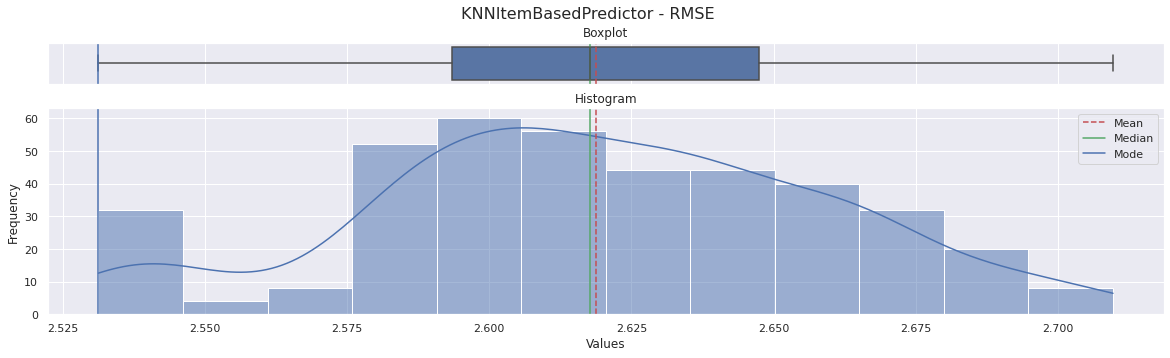


Metrics:



,RMSE
count,400.000000
mean,2.618777
std,0.040533
min,2.531259
25%,2.593478
50%,2.617712
75%,2.647417
max,2.709671


<Figure size 1440x360 with 2 Axes>

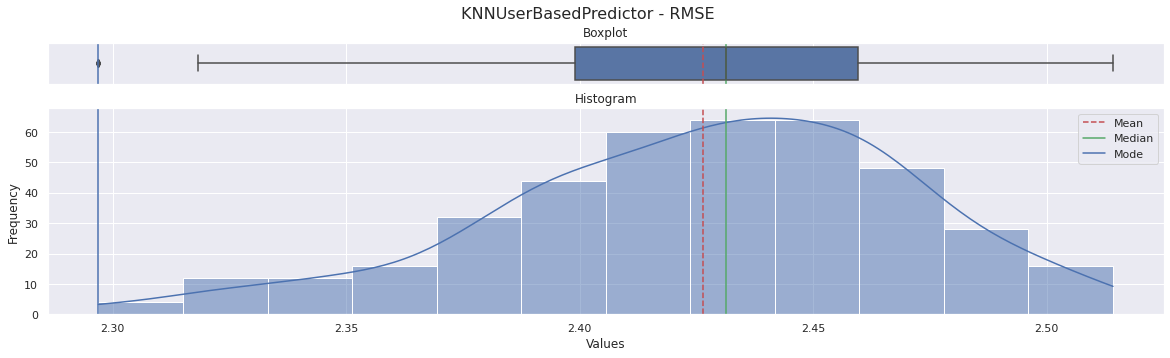


Metrics:



,RMSE
count,400.000000
mean,2.426372
std,0.044273
min,2.296959
25%,2.398924
50%,2.431363
75%,2.459521
max,2.514199


<Figure size 1440x360 with 2 Axes>

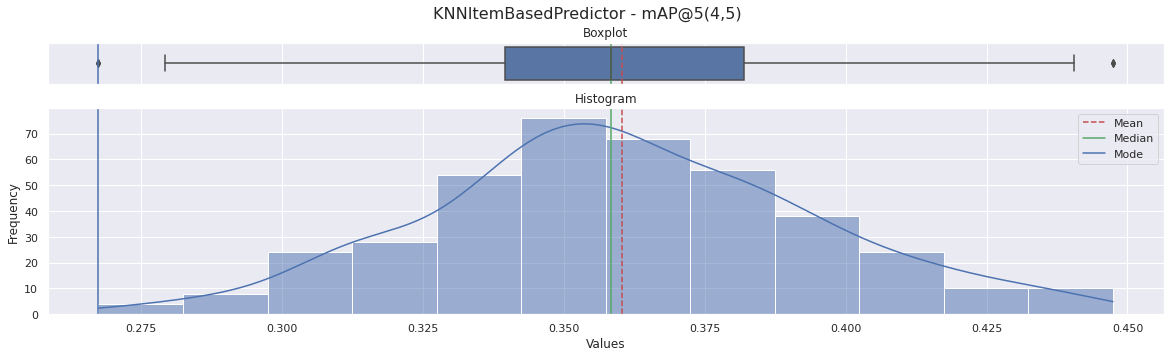


Metrics:



,"mAP@5(4,5)"
count,400.000000
mean,0.360338
std,0.034117
min,0.267466
25%,0.339640
50%,0.358425
75%,0.382005
max,0.447424


<Figure size 1440x360 with 2 Axes>

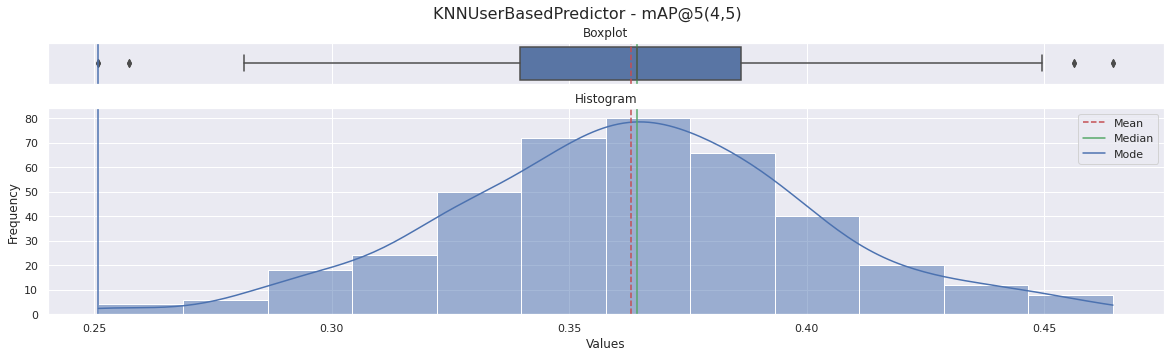


Metrics:



,"mAP@5(4,5)"
count,400.000000
mean,0.363015
std,0.037705
min,0.250886
25%,0.339738
50%,0.364211
75%,0.386181
max,0.464495


<Figure size 1440x360 with 2 Axes>

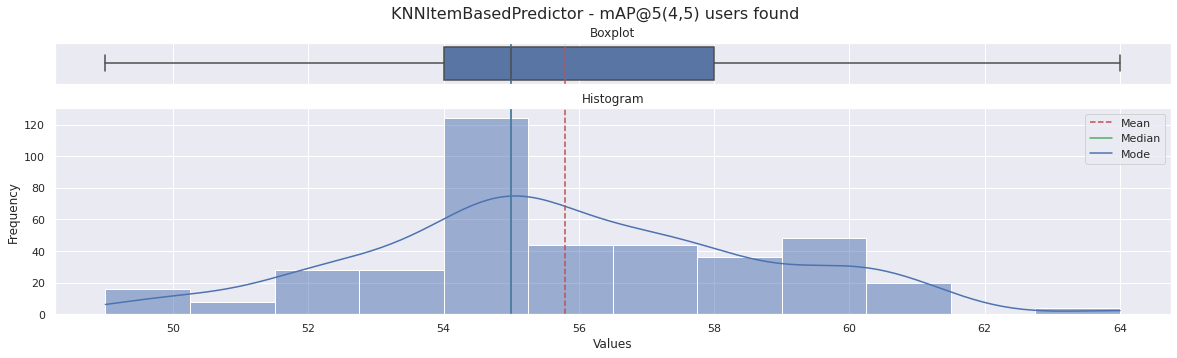


Metrics:



,"mAP@5(4,5) users found"
count,400.000000
mean,55.800000
std,2.905358
min,49.000000
25%,54.000000
50%,55.000000
75%,58.000000
max,64.000000


<Figure size 1440x360 with 2 Axes>

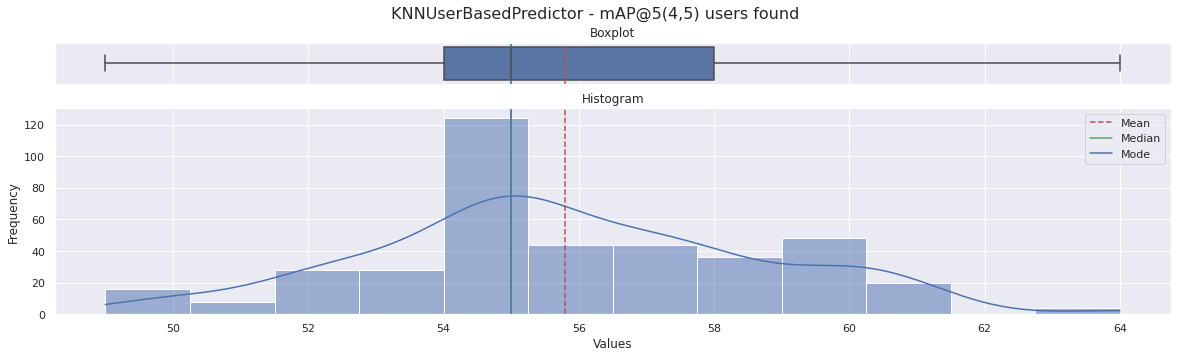


Metrics:



,"mAP@5(4,5) users found"
count,400.000000
mean,55.800000
std,2.905358
min,49.000000
25%,54.000000
50%,55.000000
75%,58.000000
max,64.000000


In [21]:
validator = ml.Validator(
    n_samples  = 100,
    batch_size = 1000,
    metrics    = [
        mt.RMSE(),
        mt.MeanAveragePrecisionAtk(user_index=0, k=5, discretizer=dr.between(4, 5))
    ],
    predictors = [user_predictor, item_predictor]
)

summary = validator.validate(eval_set, n_neighbors=100)

summary.save('../metrics/baseline')
summary = ml.ValidatorSummary.load('../metrics/baseline')

summary.plot(bins=12, show_table=True)